# Analyze A/B Test results for E-commerce Website

- **[Introduction](#intro)**  

- **[Part I - Probability](#probability)**
    - [Section I - Data Exploration](#exploration)  
    - [Section II - Data Cleaning](#cleaning)  
    - [Section III - Probability Calculation](#calculation)  

- **[Part II - A/B Test](#ab_test)**  
    - [Section I - Hypothesis Testing using the Central Limit Theory (CLT)](#CLT)  
    - [Section II - Hypothesis Testing using Built-in Methods (Z-test)](#z_test)  

- **[Part III - Regression Approach](#regression)**  

---
<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, We will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.
---
<a id='probability'></a>
## Part I - Probability
<a id='exploration'></a>
### Section I - Data Exploration
To get started, let's import our libraries.

In [47]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

#setting the seed to assure the same results
import random
random.seed(42)

Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [48]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Find the number of rows in the dataset.

In [49]:
df.shape[0]

294478

**c.** Find the number of unique users in the dataset.

In [50]:
df.user_id.nunique()

290584

**d.** Find the proportion of users converted.

In [51]:
df.converted.mean()

0.11965919355605512

**e.** Find the number of times when the `group` is not consistant with the `landing_page`.  

In [52]:
#The "group" is `treatment` but "landing_page" is not a `new_page`.
df[(df.group == 'treatment') & (df.landing_page == 'old_page')].user_id.nunique()

1965

In [53]:
#The "group" is `control` but "landing_page" is not an `old_page`.
df[(df.group == 'control') & (df.landing_page == 'new_page')].user_id.nunique()

1928

**f.** Check if any of the rows have missing values.

In [54]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**There is no missing values in our dataset.**

---
<a id='cleaning'></a>
### Section II - Data Cleaning
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


We will handle the rows where the group and landing_page columns don't match by removing these rows so that they won't affect our analysis.

**a.** Remove the inaccurate rows, and store the cleaned data in a new dataframe **df2**.

In [55]:
#Recall the no. of mismatching rows.
m1 = df[(df.group == 'treatment') & (df.landing_page == 'old_page')].user_id.nunique()
m2 = df[(df.group == 'control') & (df.landing_page == 'new_page')].user_id.nunique()
m1 + m2

3893

In [56]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[((df.group == 'treatment') & (df.landing_page == 'new_page')) 
         | ((df.group == 'control') & (df.landing_page == 'old_page'))]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [57]:
# Double Check all of the incorrect rows were removed from df2
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [58]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [59]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [60]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [61]:
# Remove one of the rows with a duplicate user_id..
# Note: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(df2[df2.user_id.duplicated()].index, inplace= True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [62]:
# Check if the row with a duplicate user_id is deleted or not.
# Output of the statement below should be 0
df2.user_id.duplicated().sum()

0

---
<a id='calculation'></a>
### Section III - Probability Calculation
**a.** What is the probability of an individual converting regardless of the page they receive?

>***We will call this propability $p_{population}$***

In [63]:
p_pop = df2.converted.mean()
p_pop

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

>***We will call this propability $p_{control}$***

In [64]:
p_cont = df2[(df2.group == 'control') & (df2.converted == 1)].shape[0] / df2[df2.group == 'control'].shape[0]
p_cont

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

>***We will call this propability $p_{treatment}$***

In [65]:
p_treat = df2[(df2.group == 'treatment') & (df2.converted == 1)].shape[0] / df2[df2.group == 'treatment'].shape[0]
p_treat

0.11880806551510564

We will now calculate our statistic of interest which is the actual/observed difference  (`obs_diff`) between the conversion rates for the two groups. 

In [66]:
# Calculate the actual/observed difference (obs_diff) between the conversion rates for the two groups.
obs_diff =  p_treat - p_cont
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [67]:
df2[df2.landing_page == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

**e.** Explain whether the new `treatment` group users lead to more conversions.

>- **We can observe that for both groups, the probability of an individual receiving either page is equal (P = 0.5)**  
>- **Hence, There is no evidence to claim that the new treatment group users lead to more conversions.**  
>- **However, The conversion rates show that 11.88% of treatment group users converted and 12.04% of control group users converted.**

---
<a id='ab_test'></a>
## Part II - A/B Test
<a id='CLT'></a>
### Section I - Hypothesis Testing using the Central Limit Theory (CLT)

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, we will consider that we need to make the decision just based on all the data provided.  

We will also assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be (**$H_0$** and **$H_1$**)?  

Now, we will state the hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the conversion rates for the old and new pages respectively.

<center>$H_0$ : $p_{new}$ - $p_{old}$ ≤ 0</center>
<center>$H_1$ : $p_{new}$ - $p_{old}$ > 0</center>
    


#### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the population conversion rate $p_{population}$ in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will complete the following: 

>- Simulate (bootstrap) sample data set for both groups, and compute the  conversion rate $p$ for those samples. 
>- Use a sample size for each group equal to the ones in the `df2` data.
>- Compute the difference in the conversion rates for the two samples above. 
>- Perform the sampling distribution for the difference in the conversion rates between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [68]:
p_new = p_pop
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [69]:
p_old = p_pop
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group?

In [70]:
n_new = df2[df2.landing_page == 'new_page'].shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [71]:
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
Note: we will use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [72]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
new_page_converted.mean()

0.11897322964696166

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [73]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
old_page_converted.mean()

0.11774990707215331

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for simulated samples

In [74]:
new_page_converted.mean() - old_page_converted.mean()

0.0012233225748083526


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process.

Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [75]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**i. Histogram**<br> 
Plot a histogram of the **`p_diffs`** array. This plot should look like a normal distribution as expected.  
Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

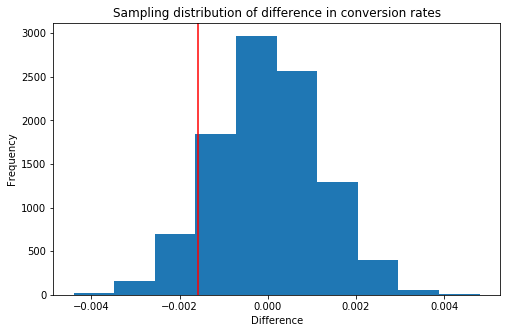

In [76]:
plt.figure(figsize=(8,5))
plt.hist(p_diffs);
plt.axvline(obs_diff, color='red');
plt.title('Sampling distribution of difference in conversion rates');
plt.xlabel('Difference');
plt.ylabel('Frequency');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [77]:
p_val = (np.array(p_diffs) > obs_diff).mean()
p_val

0.90390000000000004

**k.** Please explain in words what you have just computed above.
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages?  
 **Note**: Compare the value above with the "Type I error rate (0.05)". 

>- **The value obtained from the above section is called the P-Value; it is a conditional probability which measures the probability of obtaining the observed statistic (or more extreme results) assuming that the null hypothesis is True.**  
>>***Generally:***  
>>- *The lower the p-value (lower than the threshold Type I error rate; α = 0.05), the greater the statistical significance of the observed difference and we tend to reject the null hypothesis in the favor of the alternative hypothesis.*  
>>- *The higher the p-value (higher than the threshold Type I error rate; α = 0.05), the less the statistical significance of the observed difference and we fail to reject the null hypothesis.*

>- **In this case, the calculated p-value  is very high (p = 0.904), Hence we fail to reject the null hypothesis as the results are not statistically significant.**  
> - **We can also predict that the old page has an equal or higher probablity of conversion rate compared to the new page.**

---
<a id='z_test'></a>
### Section II - Hypothesis Testing using Built-in Methods (Z-test)

**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In the statements below, we will calculate the following:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [78]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2[(df2.landing_page == 'old_page') & (df2.converted == 1)].shape[0]

# number of conversions with the new_page
convert_new = df2[(df2.landing_page == 'new_page') & (df2.converted == 1)].shape[0]

# number of individuals who were shown the old_page
n_old = df2[df2.landing_page == 'old_page'].shape[0]

# number of individuals who received new_page
n_new = df2[df2.landing_page == 'new_page'].shape[0]

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.
The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative)
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>***Note***: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. which is our assumption, so we will use this option.

The built-in function above will return the z_score, p_value. 

---
#### *More about the two-sample Z-test*
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples. **(it's same in our case)**


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>***Note:***<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the `rejection region` in the distribution. A `rejection region` is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

In [79]:
#Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print("z = {}\np = {}".format(z_score, p_value))

z = -1.3109241984234394
p = 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the results we obtained from the above section?<br><br>

**The results obtained from this section are consistant along with the results obtained from the above section.**  
>- **The computed p-value from the Z-test (p = 0.905) is almost equal to the p-value obtained from the CLT method (p = 0.904).**  
>- **The computed z-score (z = -1.31) is less than z-critical value (z = 1.645) for a one- tailed test and a significance level (α = 0.05) .**  
>- **Accordingly, we fail to reject the null hypothesis as the results are not statistically significant.**

---
<a id='regression'></a>
### Part III - Regression Approach

In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression type will be used as it help you predict the likelihood of an event happening or a choice being made (whether an individual convert or not).**

**b.** The goal is to use **statsmodels** library to fit the regression model specified above to see if there is a significant difference in conversion based on the page type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`. 
 >***Note:*** Use `pandas.get_dummies()` to create dummy variables.

In [80]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [81]:
# Create the necessary dummy variables
dummies = pd.get_dummies(df2['group'])
df2['ab_page'] = dummies.treatment
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created above, then fit the model to predict whether or not an individual converts. 


In [82]:
# Fit your model, and summarize the results
df2['intercept'] = 1
mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = mod.fit()
print(results.summary2())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6
                          Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-06 18:01 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074



In [83]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

>**From the above results, we can interpret the following:**  
- **The conversion odds for an individual landing on the new page (in the treatment group) is 0.985 times likely than an individual landing on the old page (in the control group).**  
- **In terms of probability, the probability of conversion is (p = odds/1+odds = 49.6%) for an individual landing on the new page.**  
- **Hence, as we can observe, this finding is not statistically significant (less than 50% of individuals will convert given that they land on the new page).**  
- **Finally, We fail to reject the null hypothesis, The new page shouldn't be implemented as there is no evidence that it is better than the old page.**

**d.** What is the p-value associated with **ab_page**? Why does it differ from the value you found previously?<br><br>  

***Notes***: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>- **The p-value associated with ab_page is (p = 0.19) and it is again higher than our Type I error rate; (α = 0.05).**  
>- **Therefore, we fail to reject the null hypothesis as the results are not statistically significant.**  
>- **Moreover, the p-value here (p = 0.19) differs from the p-value obtained from the above section (p = 0.907) as the regression model is testing if the difference in conversion rates is equal to zero. (i.e. two tailed non-directional test).**  

<center>$H_0$ : $p_{new}$ - $p_{old}$ = 0</center>
<center>$H_1$ : $p_{new}$ - $p_{old}$ ≠ 0</center>


**e.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>- **I think it is a good idea to consider other factors to add into our regression model as it will add depth to our analysis and improve our model predicition capabilities so that our model will be more reliable.**   
>- **However, we should be very careful as there are some issues that might arise due to adding more factors such as multicollinearity and interactions, we need to make sure that our independant variables have no correlation to each other.**

---
**f. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>***Note*** Use `pandas.get_dummies()` to create dummy variables,  
and `pandas.join()` to join the resulting dataframe to the original dataframe.

In [84]:
# Read the countries.csv
df_contries = pd.read_csv('countries.csv')
df_contries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [85]:
# Join with the df2 dataframe
df_merged = df2.set_index('user_id').join(df_contries.set_index('user_id'), how='inner')
df_merged.reset_index(inplace=True)
df_merged.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [86]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


In [87]:
# Fit your model (consider that US is the baseline here), and summarize the results
df_merged['intercept'] =1
mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'CA', 'UK']])
results = mod.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6
                          Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-06 18:01 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.455

In [88]:
np.exp(results.params)

intercept    0.135779
CA           0.960018
UK           1.009966
dtype: float64

>**From the above results, we can interpret the following:**  
- **For CA: The conversion odds for an individual landing on the new page (in the treatment group) is 0.96 times likely than an individual landing on the old page (in the control group) compared to our baseline US.**  
- **For UK: The conversion odds for an individual landing on the new page (in the treatment group) is 1.01 times likely than an individual landing on the old page (in the control group) compared to our baseline US.**  
- **This means that conversion rates in CA < US < UK, However the margin is very low that the conversion rate is not significant.**   
- **Hence, as we can observe, this finding is not statistically significant (country doesn't have influence on the conversion rate).**  
- **Finally, We fail to reject the null hypothesis, The new page shouldn't be implemented as there is no evidence that it is better than the old page with respect to country.**

---
**g. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 

>***Notes***: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [89]:
#Create new intereacton variables between ab_page and country
df_merged['ab_page_CA'] = df_merged['ab_page'] * df_merged['CA']
df_merged['ab_page_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_page_US'] = df_merged['ab_page'] * df_merged['US']
df_merged.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US,ab_page_CA,ab_page_UK,ab_page_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1,0,0,0


In [90]:
# Fit your model, and summarize the results
df_merged['intercept'] =1
mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'UK', 'ab_page_CA', 'ab_page_UK']])
results = mod.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                          Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-06 18:01 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.641

In [91]:
np.exp(results.params)

intercept     0.137178
ab_page       0.979646
CA            0.982625
UK            0.994272
ab_page_CA    0.954198
ab_page_UK    1.031896
dtype: float64

>**From the above results, we can interpret the following:**  
- **The p-value associated with all variables is higher than our Type I error rate; (α = 0.05).**  
- **It is unlikely that there is relationship between landing page or country on the conversion rates.**  
- **Therefore, we fail to reject the null hypothesis as the results are not statistically significant.**   
- **Finally, We can conclude that, The new page shouldn't be implemented as there is no evidence that it is better than the old page.**

In [93]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0